In [28]:
#Imports
import pandas as pd
import numpy as np 
import nilearn 
import nibabel as nib
import os
import matplotlib.pyplot as plt
import glob

from nilearn import plotting, image
from nilearn.glm.first_level import compute_regressor
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn.maskers import NiftiMasker
from nilearn.plotting import plot_design_matrix
from nilearn import image
from nilearn import masking
from numpy import savetxt
from nilearn.maskers import NiftiSpheresMasker
from nilearn.reporting import get_clusters_table


#Submit job to HPC
#subprocess.call(['qsub', '-l', 'procs=1,mem=24gb,walltime=12:00:00 -I'])

# Init variables
init_folder='/home/traaffneu/margal/code/multirat_se/script/'
analysis_folder='/project/4180000.19/multirat_stim/rabies/preprocess'
            
# Data path
template_path ='/groupshare/traaffneu/preclinimg/templates/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Template.nii'
metadata_path ='/home/traaffneu/margal/code/multirat_se/script/table/metadata_stand.tsv'
mask = '/groupshare/traaffneu/preclinimg/templates/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Mask.nii'
metadata_rabies='/home/traaffneu/margal/code/multirat_se/script/table/metadata_rabies.tsv'


# Output directories

output_dir = '/project/4180000.19/multirat_stim/rabies_test/first_level_analysis/'
matrix_dir = os.path.join(output_dir, 'matrix/')
image_dir = os.path.join(output_dir, 'image/')
residuals_dir = os.path.join(output_dir, 'residuals/')
z_score_dir = os.path.join(output_dir, 'z_score/')
beta_dir = os.path.join(output_dir, 'beta_estimates/')
effect_var_dir = os.path.join(output_dir, 'effect_var/')
predicted_timeseries_dir = os.path.join(output_dir, 'predicted_timeseries/')


if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(matrix_dir):
    os.makedirs(matrix_dir)
if not os.path.exists(image_dir):
    os.makedirs(image_dir)
if not os.path.exists(residuals_dir):
    os.makedirs(residuals_dir)
if not os.path.exists(z_score_dir):
    os.makedirs(z_score_dir)
if not os.path.exists(beta_dir):
    os.makedirs(beta_dir)
if not os.path.exists(effect_var_dir):
    os.makedirs(effect_var_dir)
if not os.path.exists(predicted_timeseries_dir):
    os.makedirs(predicted_timeseries_dir)

In [24]:
#Fitted time course of the rat HRF --> Parameters: b = 2.0,   p1 = 7.4, p2 = 8.9 and V = 1.5), peak 0.1 ms 

import numpy as np
from scipy.stats import gamma

def rat_hrf(tr, n_trs):
    
    b = 2.0   # Define the parameters of the rat HRF
    p1 = 7.4
    p2 = 8.9
    V = 1.5
    
    t = np.arange(0, n_trs*tr, tr)     #calculates the exact sequence of time points that correspond to each TR --> time points for the HRF in sec

    hrf_model = ((t-b)**(p1-1) * np.exp(-(t-b)/p2) / (p2**p1 * np.math.gamma(p1))) - V * ((t-b)**(p1-1) * np.exp(-(t-b)/p2) / (p2**p1 * np.math.gamma(p1)))

    # plt.plot(t, hrf_model)
    # plt.xlabel('Time (s)')
    # plt.ylabel('HRF amplitude')
    # plt.title('Rat HRF Model')
    # plt.show()


#rat_func(tr=1.5, n_trs=100)


index: 0
subj: 200100
n_stimulation: 3


/scratch/margal/49128933.dccn-l029.dccn.nl/ipykernel_18724/3191328465.py:15: RuntimeWarning: invalid value encountered in power
  hrf_model = ((t-b)**(p1-1) * np.exp(-(t-b)/p2) / (p2**p1 * np.math.gamma(p1))) - V * ((t-b)**(p1-1) * np.exp(-(t-b)/p2) / (p2**p1 * np.math.gamma(p1)))
/scratch/margal/49128933.dccn-l029.dccn.nl/ipykernel_18724/489166414.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  events_list = events.append(events)
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:74: UserWarning: 'trial_type' column not found in the given events data.
  warnings.warn("'trial_type' column not found "


Contrasts:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/_utils/glm.py:335: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1. / X)


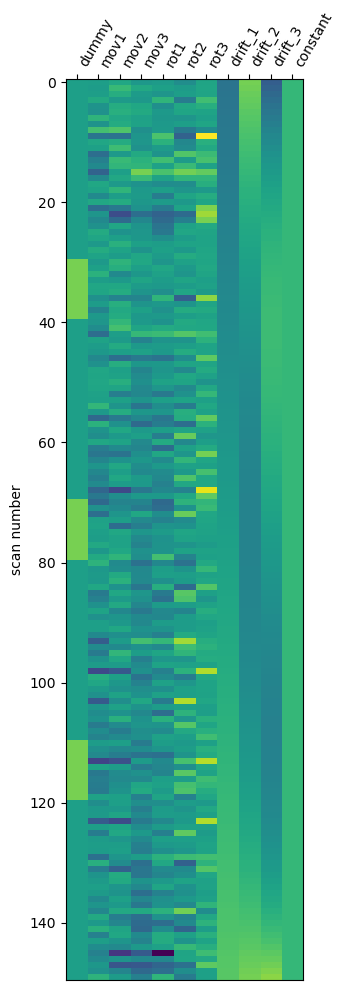

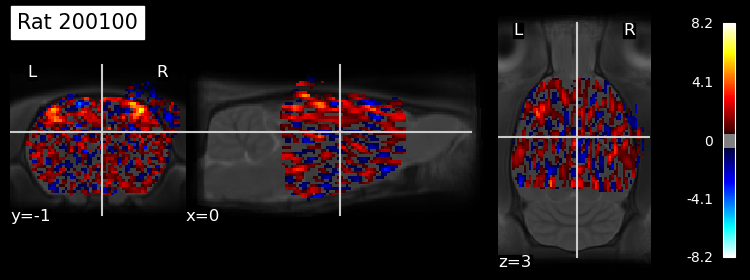

In [33]:
# ---------- FIRST LEVEL ANALYSIS ------------

df = pd.read_csv(metadata_path, sep='\t')
df = df.loc[(df['exclude'] != 'yes')]

for index in range(0, 1):
    
    subj_num=str(df.iloc[index]['rat.sub'])[:-2]
    print('index:', index)
    print('subj:', subj_num)
    
    subject_path = glob.glob(analysis_folder + "/sub-0{}_ses-1/bold_datasink/commonspace_bold/*/*/*.nii.gz".format(subj_num, subj_num, subj_num))[0]

    
    # --- Specify the rat hrf --- 
    
    tr = (df.iloc[index]['func.TR'])
    n_trs = np.count_nonzero((np.matrix(df.iloc[index]['func.sensory.onset']))) #count number of stimulation, number of onset
    hrf_model = rat_hrf(tr, n_trs)
    print('n_stimulation:', n_trs)
    
    func_img = nib.load(subject_path)                                
    header = func_img.header

    n_scans = func_img.shape[3]    
    frame_times = np.arange(n_scans) * tr                             # corresponding frame times    
    

    # --- Events regressor --- 
    
    onset = np.matrix(df.iloc[index]['func.sensory.onset']).A[0]
    duration = np.matrix(df.iloc[index]['func.sensory.duration']).A[0]
    events = pd.DataFrame({'onset': onset,'duration': duration})
    events_list = events.append(events)
    
    
    # --- Motion regressors ---

    cofounders_file = 'sub-0{}_ses-1_run-1_bold_RAS_combined_confounds.csv'.format(subj_num)
    cofounders_path = glob.glob(analysis_folder +"/sub-0{}_ses-1/confounds_datasink/confounds_csv/*/*/*.csv".format(subj_num, subj_num, subj_num, subj_num))[0]


    cofounders = pd.read_csv(cofounders_path, sep=',')

    motion_names = ['mov1', 'mov2', 'mov3', 'rot1', 'rot2', 'rot3']
    motion = np.array(cofounders[motion_names])
    
    
    # --- Compute design matrix --- 
   
    design_matrix = make_first_level_design_matrix(frame_times=frame_times, 
                                                   events=events, 
                                                   add_regs=motion, 
                                                   add_reg_names=motion_names, 
                                                   drift_model="polynomial", 
                                                   drift_order=3, 
                                                   hrf_model=hrf_model, 
                                                   high_pass=0.01)
    plot_design_matrix(design_matrix) 
    savetxt(matrix_dir+'matrix_sub-0{}_ses-1.csv'.format(subj_num), design_matrix, delimiter=',')


    # --- Fitting a first-level model --- 
    
    fmri_glm = FirstLevelModel(t_r=7,
                               drift_model='polynomial',
                               signal_scaling=False,
                               minimize_memory=False)
    
    fmri_glm = fmri_glm.fit(subject_path, design_matrices=design_matrix)

    residuals = fmri_glm.residuals[0]
    predicted_timeseries = fmri_glm.predicted[0]
    
    nib.save(residuals, residuals_dir+'residuals_sub-0{}_ses-1.nii.gz'.format(subj_num))         #save this to nifti
    nib.save(predicted_timeseries, predicted_timeseries_dir+'predicted_timeseries_sub-0{}_ses-1.nii.gz'.format(subj_num))  
    
    # -- Coompute contrasts ---
    
    n_columns = design_matrix.shape[1]
    contrast_val = np.hstack(([1], np.zeros(n_columns - 1)))
    print('Contrasts: ', contrast_val)

    statistical_map = fmri_glm.compute_contrast(contrast_val, output_type='all')
    
    nib.save(statistical_map['z_score'], z_score_dir+'z_score_sub-0{}_ses-1.nii.gz'.format(subj_num))           #save z map
    nib.save(statistical_map['effect_size'], beta_dir+'beta_sub-0{}_ses-1.nii.gz'.format(subj_num))             #save the betaestimates
    nib.save(statistical_map['effect_variance'], effect_var_dir+'effect_var_sub-0{}_ses-1.nii.gz'.format(subj_num))  #save the betaestimates

    #-- Plot and save as nifti file ---
    
    plot_stat = plotting.plot_stat_map(statistical_map['z_score'], 
                                       bg_img = template_path, 
                                       threshold = 0.5, 
                                       title = 'Rat {}'.format(subj_num))
    
    plt.savefig(image_dir+'stat_map_sub-0{}_ses-1.png'.format(subj_num))

In [31]:
    # -- Extract clusters --

    from nilearn.reporting import get_clusters_table
    from nilearn.maskers import NiftiSpheresMasker

    table = get_clusters_table(statistical_map['z_score'],
                            stat_threshold=3.0,
                            cluster_threshold=20)


    table.set_index("Cluster ID", drop=True)
    coords = table.loc[range(0, len(table)), ['X', 'Y', 'Z']].values                     # get the clusters' x, y, and z coordinates (if want the 4 largest, range(0, 4)
    
    
    masker = NiftiSpheresMasker(coords)                                                  # extracts time series data from a set of spherical regions of interest (ROIs) in a 3D fMRI image
    print(table)
    
    real_timeseries = masker.fit_transform(subject_path)                                 # applies the masker to an fMRI image, outputs 2D numpy array
    predicted_timeseries = masker.fit_transform(fmri_glm.predicted[0])
    clusters_residuals = masker.fit_transform(fmri_glm.residuals[0])
    
    
    #savetxt(clusters_coords_dir+'cluster_timesries_sub-0{}_ses-1.csv'.format(subj_num), coords, delimiter=',')                   # save as .csv file
    #savetxt(clusters_timeseries_dir+'cluster_timesries_sub-0{}_ses-1.csv'.format(subj_num), real_timeseries, delimiter=',')             
    #savetxt(predicted_timeseries_dir+'cluster_predicted_timeseries_sub-0{}_ses-1.csv'.format(subj_num), predicted_timeseries, delimiter=',')       
    #savetxt(clusters_residuals_dir+'clusters_residuals_sub-0{}_ses-1.csv'.format(subj_num), clusters_residuals, delimiter=',')      


   Cluster ID         X         Y         Z  Peak Stat  Cluster Size (mm3)
0           1  4.060001  1.390001  4.335001   8.204623                  29
1           2 -5.839999  1.390001  4.635001   7.761922                  30
2           3  0.160001 -5.809999  5.835001   4.938213                   0
3           4 -0.139999 -2.809999  4.935001   4.918215                   1
4           5 -0.739999 -4.609999  6.135001   4.599831                   0


Cluster 0 peak[4.06000096 1.3900013  4.33500057]

Cluster 1 peak[-5.83999944  1.3900013   4.63500059]

Cluster 2 peak[ 0.1600008  -5.80999899  5.83500063]

Cluster 3 peak[-0.13999921 -2.80999887  4.9350006 ]

Cluster 4 peak[-0.73999923 -4.60999894  6.13500065]



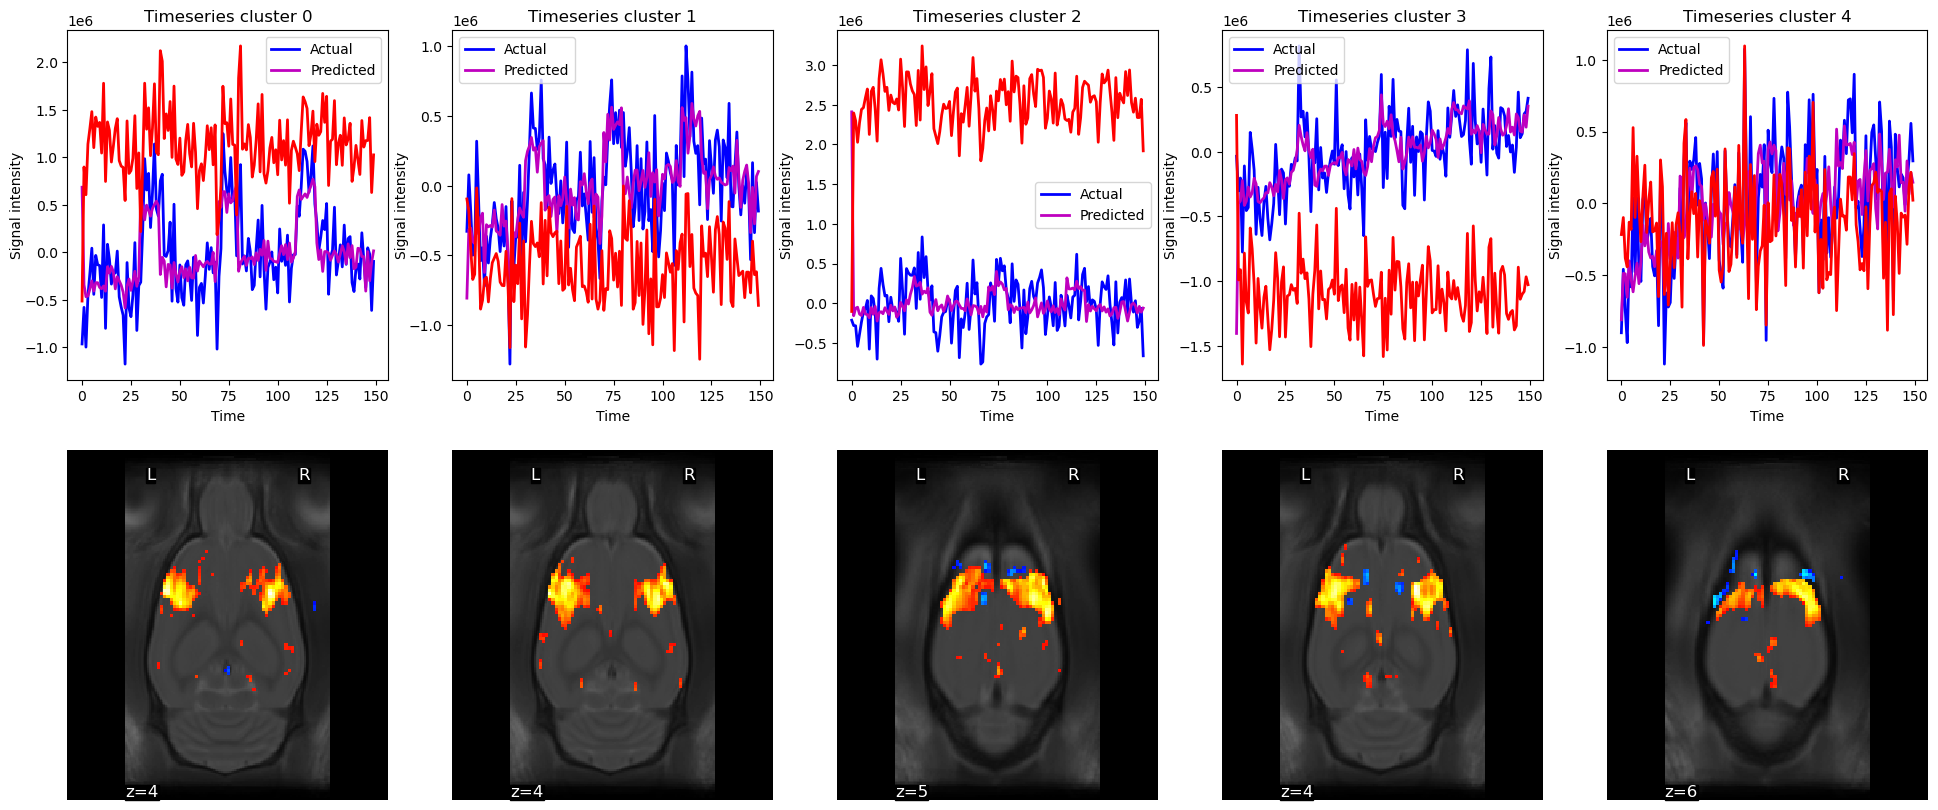

In [32]:
#Plot timeseries per cluster 

#Correct for differences in baseline levels between the predicted and real time series
predicted_mean = np.mean(predicted_timeseries, axis=0)
real_mean = np.mean(real_timeseries, axis=0)

corrected_predicted = np.subtract(predicted_timeseries, predicted_mean)
corrected_real = np.subtract(real_timeseries, real_mean)

fig1, axs1 = plt.subplots(2, len(table))

for i in range(0, len(table)):
    axs1[0, i].set_title("Timeseries cluster {}".format(i))

    axs1[0, i].plot(corrected_real[:, i], c='b', lw=2, label="Actual")
    axs1[0, i].plot(corrected_predicted[:, i], c="m", ls="-", lw=2, label="Predicted")
    axs1[0, i].plot(clusters_residuals[:, i], c='r', lw=2)
    axs1[0, i].legend()

    axs1[0, i].set_xlabel("Time")
    axs1[0, i].set_ylabel("Signal intensity", labelpad=0)
   
   
# plotting image below the time series
    roi_img = plotting.plot_stat_map(statistical_map['z_score'],
                                    cut_coords=[coords[i][2]],
                                    threshold=3.1,
                                    figure=fig1,
                                    axes=axs1[1, i],
                                    display_mode="z",
                                    colorbar=False,
                                    bg_img = template_path)
    
    fig1.set_size_inches(24, 10)
    print('Cluster {} peak'.format(i)+f'{coords[i]}\n')
  